In [111]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform
import random
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm
from sklearn.metrics import silhouette_score, r2_score

## Первичная обработка данных

In [112]:
X = pd.read_excel("data/X_4_14.xlsx", names=[f"feature_{i}" for i in range(4)])
# Y = pd.read_excel('data/Y_4_14.xlsx', header=None)

In [113]:
X.describe()

,feature_0,feature_1,feature_2,feature_3
count,199.000000,199.000000,199.000000,199.000000
mean,2.989366,0.978693,3.042654,-0.053288
std,2.667961,1.193916,2.627396,1.657722
min,-1.770611,-1.098890,-1.686545,-3.001601
25%,0.950759,0.094083,1.015519,-1.329454
50%,3.036132,1.012075,2.999677,0.001223
75%,5.021846,1.939613,5.048610,1.153452
max,7.684823,3.085918,8.097899,3.110166


#### Проверка на выбросы

In [114]:
X.isna().sum()

feature_0    0
feature_1    0
feature_2    0
feature_3    0
dtype: int64

<Axes: >

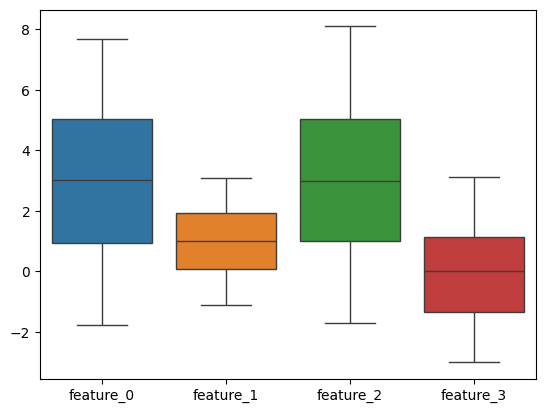

In [115]:
sns.boxplot(X)

In [116]:
X = MinMaxScaler().fit_transform(X)

<Axes: >

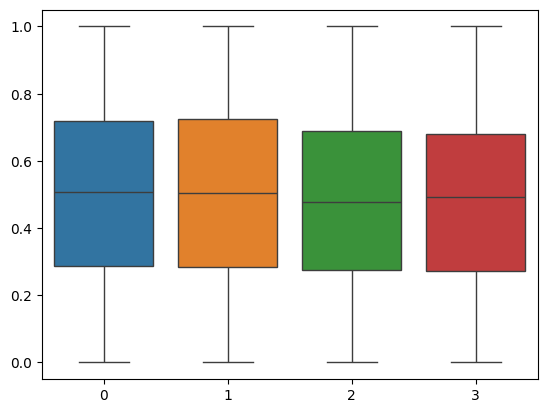

In [117]:
sns.boxplot(X)

Вложим наши наблюдения на двумерие с помощью PCA для визуализации

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_2d = pca.fit_transform(X)

<Axes: title={'center': 'Двумерная карта наблюдений'}, xlabel='pca_feature1', ylabel='pca_feature2'>

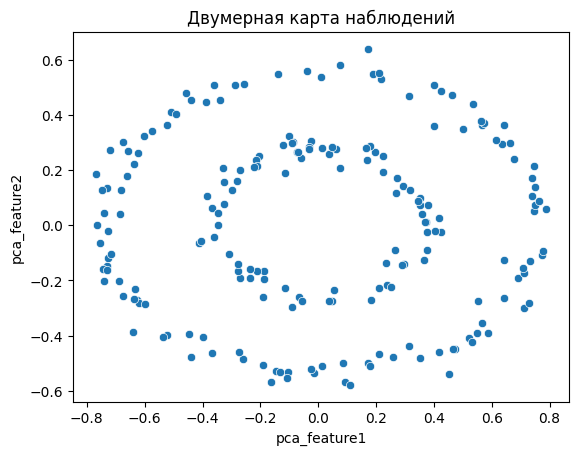

In [119]:
plt.title('Двумерная карта наблюдений')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1])

## Подготовка данных

#### Вычисление матрицы расстояний

In [120]:
def get_dist_matrix(matrix, metric="euclidean"):
    if metric == "minkowski":
        dist_vector = pdist(matrix, metric=metric, p=4)
    else:
        dist_vector = pdist(matrix, metric=metric)
    return squareform(dist_vector)

In [121]:
d_matrix_euclidean = get_dist_matrix(X, metric="euclidean")

#### Вычисление similarity-матрицы 

In [122]:
def get_similarity_matrix(d_matrix):
    sim_matrix = 1 / (1 + d_matrix)
    return sim_matrix

In [123]:
sim_matrix = get_similarity_matrix(d_matrix_euclidean)

In [124]:
sim_matrix

array([[1.        , 0.91946186, 0.7951142 , ..., 0.90640979, 0.98974981,
        0.90863589],
       [0.91946186, 1.        , 0.77365003, ..., 0.84300768, 0.92126408,
        0.84814405],
       [0.7951142 , 0.77365003, 1.        , ..., 0.77242397, 0.78862048,
        0.76426009],
       ...,
       [0.90640979, 0.84300768, 0.77242397, ..., 1.        , 0.90749117,
        0.9814644 ],
       [0.98974981, 0.92126408, 0.78862048, ..., 0.90749117, 1.        ,
        0.91126384],
       [0.90863589, 0.84814405, 0.76426009, ..., 0.9814644 , 0.91126384,
        1.        ]])

<Axes: >

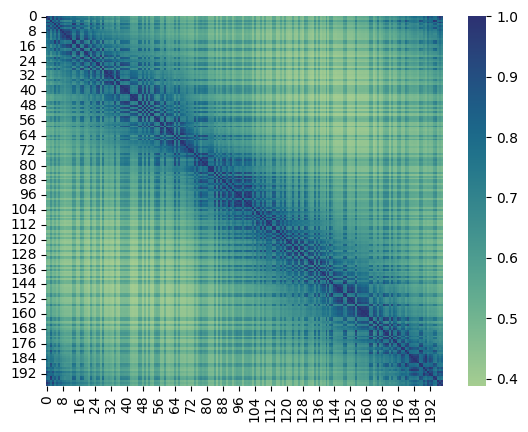

In [125]:
sns.heatmap(sim_matrix, cmap="crest")

Таким образом мы перешли к графовой модели, представленной матрицей схожести. Наблюдения из начальной таблицы стали вершинами графа, а схожесть наблюдений с индексами i и j - ребрами. Значение элемента [i, j] матрицы sim_matrix является весов ребра в нашем графе.

## Кластеризация для числа кластеров k=2

#### Кластеризация методом MST

Для кластеризации этим методом мы используем библиотеку networkx. Мы инициализируем граф и находим для него MST с помощью метода maximum_spanning_tree из этой библиотеки. Этот метод использует алгоритм Краскала для нахождения MST.

<Figure size 800x600 with 0 Axes>

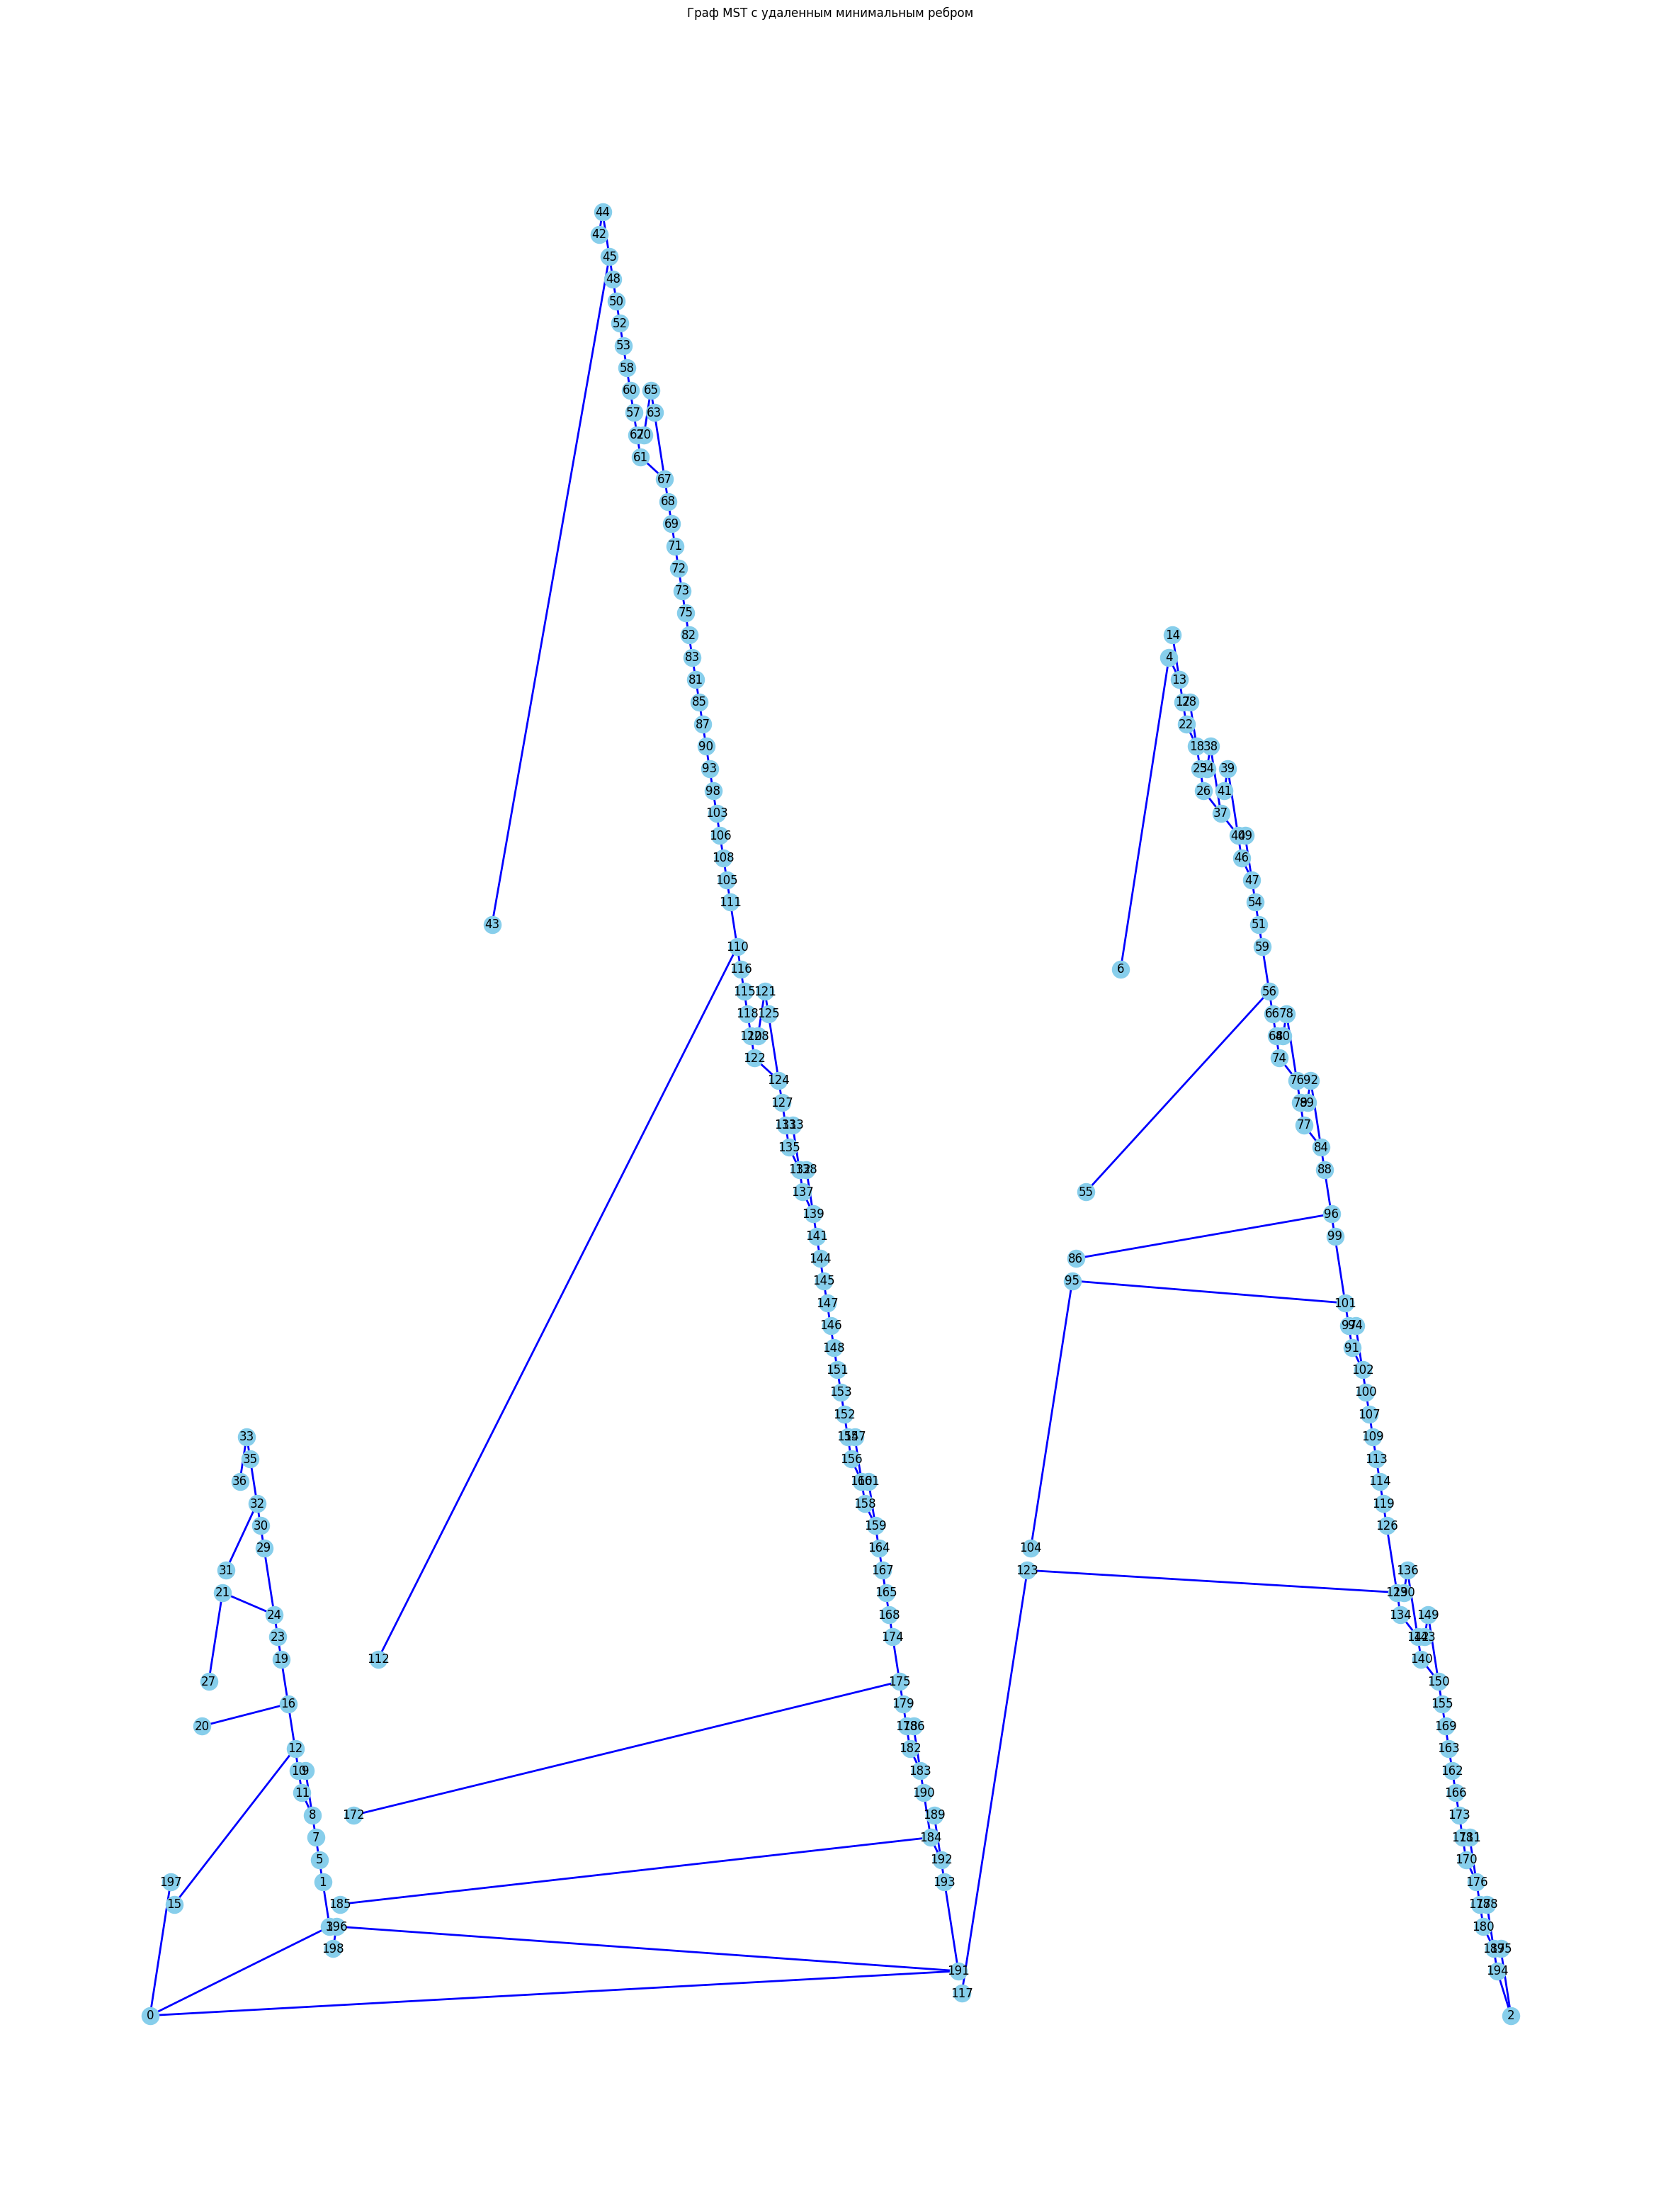

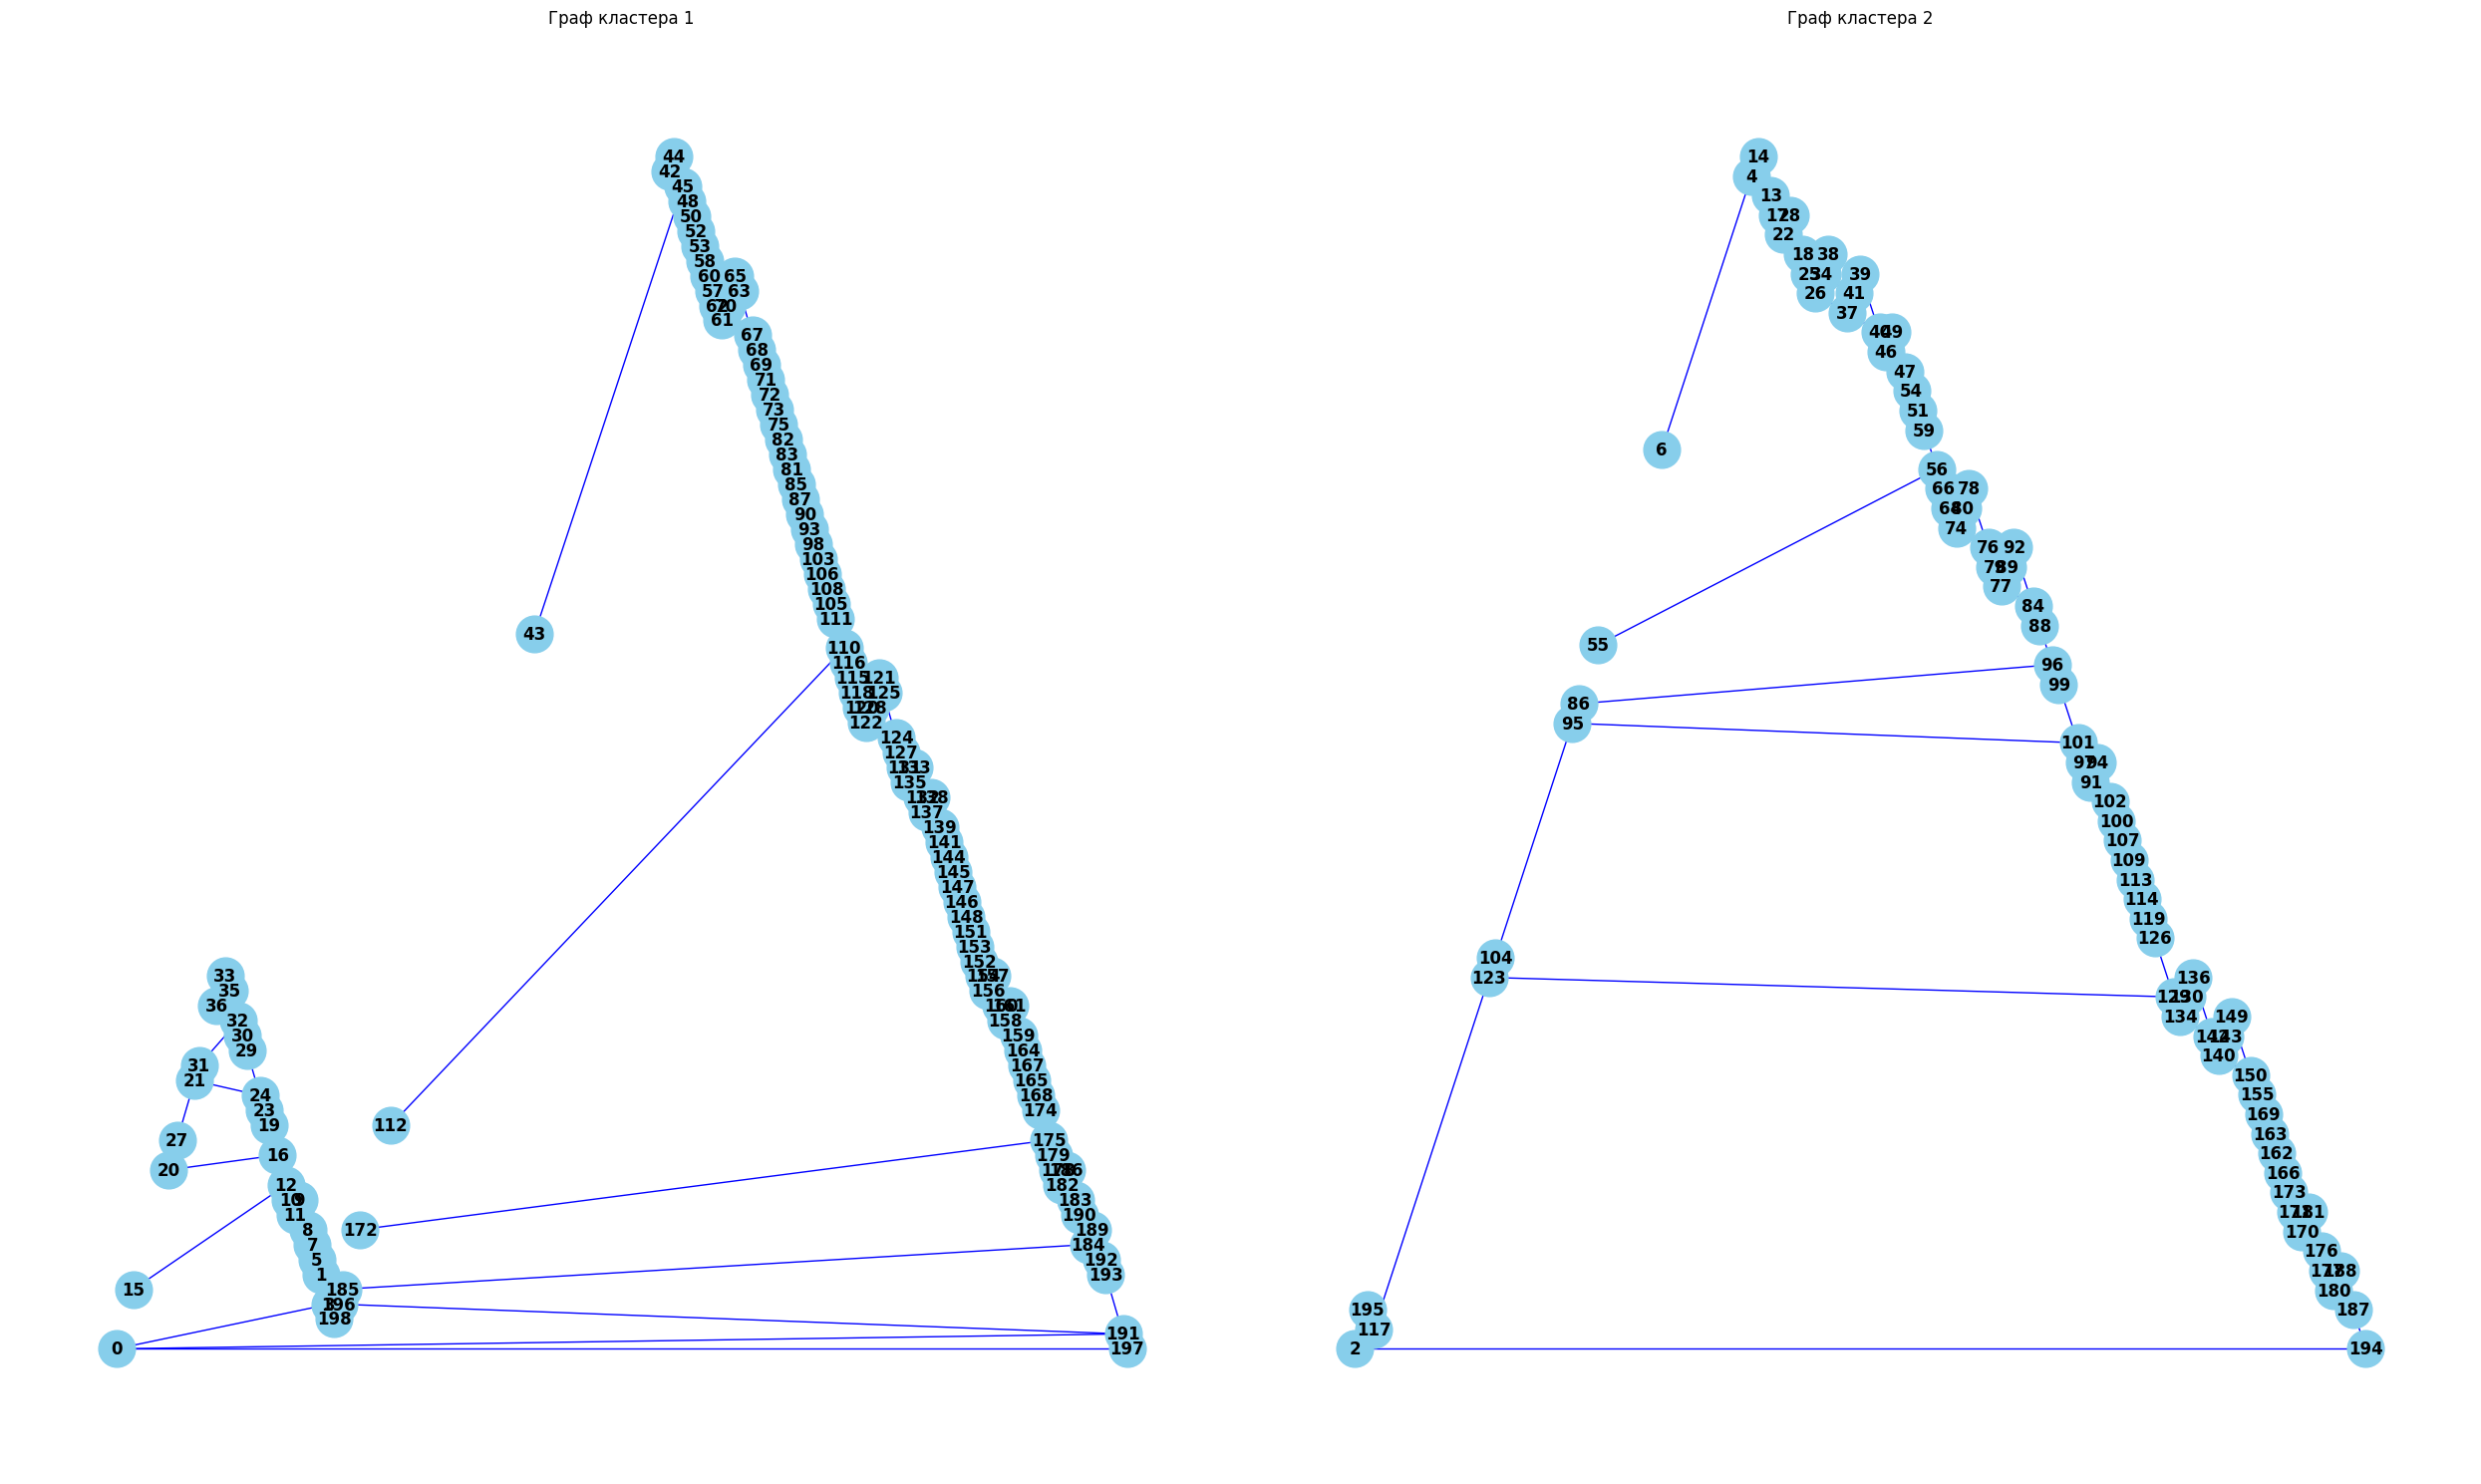

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]


In [126]:
G = nx.Graph()
num_points = X.shape[0]

# Добавляем узлы
G.add_nodes_from(range(num_points))

# Добавляем рёбра с весами
for i in range(num_points):
    for j in range(i + 1, num_points):
        G.add_edge(i, j, weight=sim_matrix[i, j])

# Построение максимального остовного дерева (MST) алгоритмом Краскала
mst = nx.maximum_spanning_tree(G)

# Удаление самого короткого ребра
sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]["weight"])
shortest_edge = sorted_edges[0]  # самое короткое ребро
mst.remove_edge(shortest_edge[0], shortest_edge[1])

# Получаем компоненты связности
clusters_mst = list(nx.connected_components(mst))

# Визуализация
plt.figure(figsize=(8, 6))

# Рисуем MST
plt.figure(figsize=(30, 40))
plt.title("Граф MST с удаленным минимальным ребром")
nx.draw_planar(mst, node_color="skyblue", edge_color="blue", with_labels=True, width=2)
plt.show()

plt.figure(figsize=(25, 15))

for i, cluster in enumerate(clusters_mst, start=1):
    subgraph = mst.subgraph(cluster)  # Создаём подграф для кластера

    plt.subplot(1, 2, i)
    nx.draw_planar(
        subgraph,
        with_labels=True,
        node_color="skyblue",
        edge_color="blue",
        node_size=700,
        font_weight="bold",
    )
    plt.title(f"Граф кластера {i}")
    plt.xlabel("X")
    plt.ylabel("Y")

plt.tight_layout()
plt.show()

for i, cluster in enumerate(clusters_mst, start=1):
    print(f"Кластер {i}: {sorted(cluster)}")

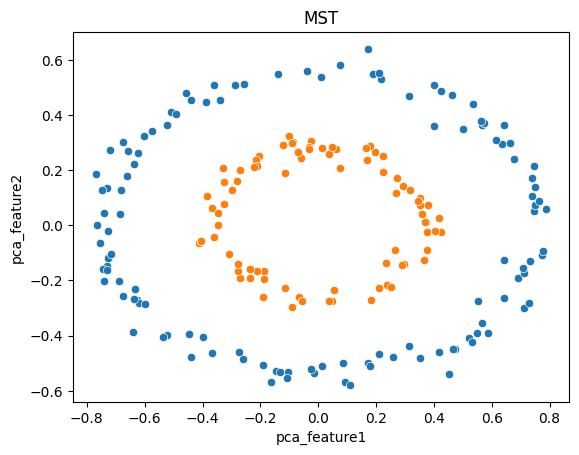

In [127]:
plt.title('MST')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst)):
    sns.scatterplot(x=data_2d[list(clusters_mst[i])][:, 0], y=data_2d[list(clusters_mst[i])][:, 1])

#### Кластеризация методом K-Means

Использовалась реализация из библиотеки sklearn

In [128]:
kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(X)
labels_kmeans = kmeans.predict(X)
cluster1 = np.arange(0, 199)[labels_kmeans == 1]
cluster2 = np.arange(0, 199)[labels_kmeans == 0]
clusters_kmeans = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]
Кластер 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 191, 194, 195, 196, 197, 198]


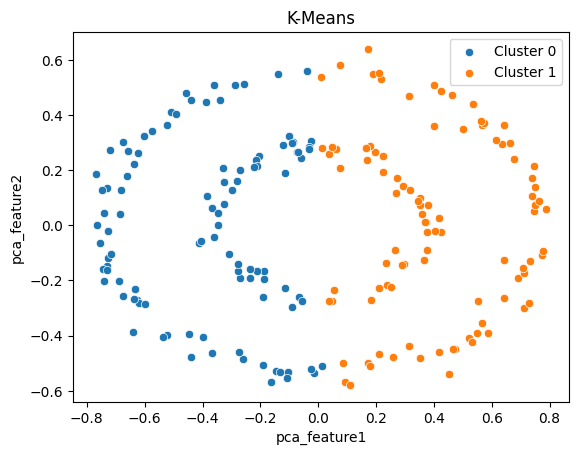

In [129]:
plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')

Чтобы нарисовать центры, полученные алгоритмом, применим его к данным вложенным в двумерие

In [130]:
kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(data_2d)
labels = kmeans.predict(data_2d)
cluster1 = np.arange(0, 199)[labels == 1]
cluster2 = np.arange(0, 199)[labels == 0]
clusters_kmeans = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]
Кластер 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 191, 194, 195, 196, 197, 198]


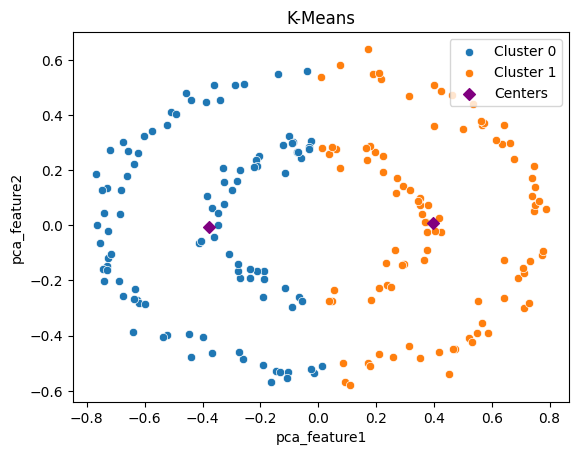

In [131]:
centroids = kmeans.cluster_centers_

plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='D', label='Centers', color='purple')
plt.legend(loc='upper right')

#### Кластеризация EM-алгоритмом

Использовалась реализация этого алгоритма из библиотеки sklearn

In [132]:
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=54)
gmm.fit(X)
labels_em = gmm.predict(X)
cluster1 = np.arange(0, 199)[labels_em == 1]
cluster2 = np.arange(0, 199)[labels_em == 0]
clusters_em = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 89, 92, 191, 194, 195, 196, 197, 198]
Кластер 2: [84, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]


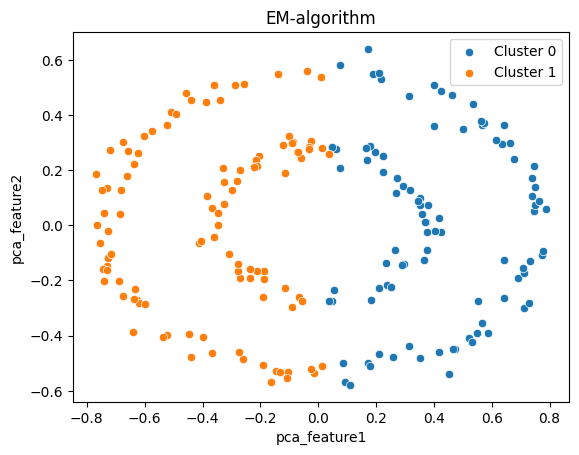

In [133]:
plt.title('EM-algorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

Кластеризация EM-алгоритмом на двумерных данных для визуализации результатов

In [134]:
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=54)
gmm.fit(data_2d)
labels = gmm.predict(data_2d)
cluster1 = np.arange(0, 199)[labels == 1]
cluster2 = np.arange(0, 199)[labels == 0]
clusters_em = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 89, 92, 191, 194, 195, 196, 197, 198]
Кластер 2: [84, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]


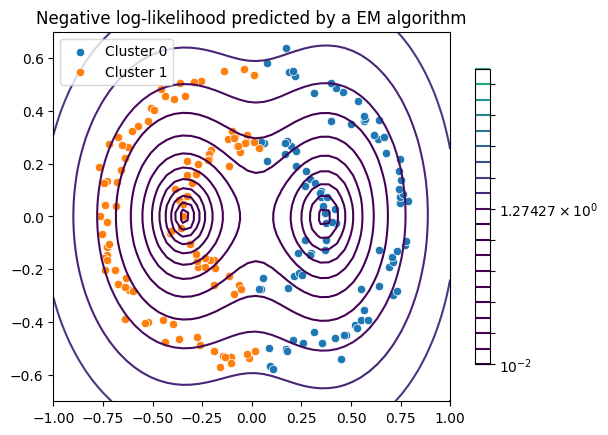

In [135]:
x = np.linspace(-1, 1)
y = np.linspace(-0.7, 0.7)
X_, Y_ = np.meshgrid(x, y)
XX = np.array([X_.ravel(), Y_.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_.shape)

CS = plt.contour(
    X_, Y_, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(-2, 2, 20)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
# plt.scatter(data_2d[:, 0], data_2d[:, 1], 0.8)
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

plt.title("Negative log-likelihood predicted by a EM algorithm")
plt.axis("tight")
plt.show()

#### Кластеризация Unnormalized Spectral методом

In [136]:
W = sim_matrix
D = np.diag([W.shape[0] for _ in range(W.shape[0])])
L = D - W

In [137]:
eig_vals, eig_vecs = np.linalg.eigh(L)
eig_vecs_2 = eig_vecs[:, :2]
kmeans = KMeans(n_clusters=2, n_init=50)
labels_spectral = kmeans.fit_predict(eig_vecs_2)
cluster1 = np.arange(0, 199)[labels_spectral == 1]
cluster2 = np.arange(0, 199)[labels_spectral == 0]
clusters_spectral = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_spectral, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192]
Кластер 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 191, 193, 194, 195, 196, 197, 198]


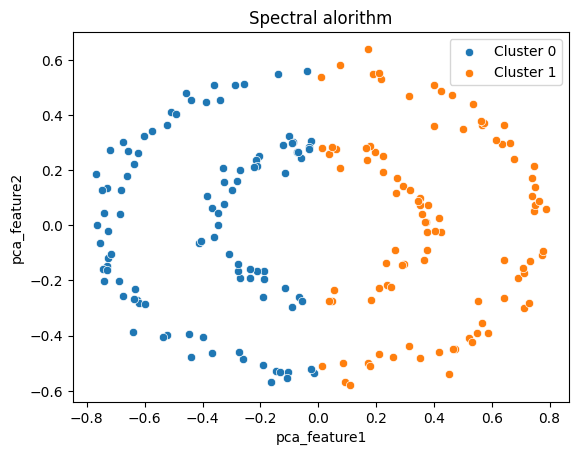

In [138]:
plt.title('Spectral alorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_spectral)):
    sns.scatterplot(x=data_2d[list(clusters_spectral[i])][:, 0], y=data_2d[list(clusters_spectral[i])][:, 1],
                    label=f'Cluster {i}')

#### Подсчет RAND индекса

Сравнение разбиений попарно

In [139]:
def count_pairs_disjoin(left_set: set, right_sets: list):
    left_set_pairs_cnt = len(left_set) * (len(left_set) - 1)

    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt - len(separation) * (
            len(separation) - 1
        )

    return left_set_pairs_cnt


def count_pairs_join(left_set: set, right_sets: list):
    left_set_pairs_cnt = 0

    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt + len(separation) * (
            len(separation) - 1
        )

    return left_set_pairs_cnt


def get_rand_index(part1: list, part2: list):
    left_sets = part1
    right_sets = part2

    left_pair_union = sum([count_pairs_join(x, right_sets) for x in left_sets])
    right_pair_union = sum([count_pairs_join(x, left_sets) for x in right_sets])

    union_cnt = left_pair_union + right_pair_union

    left_pair_diff = sum([count_pairs_disjoin(x, right_sets) for x in left_sets])
    right_pair_diff = sum([count_pairs_disjoin(x, left_sets) for x in right_sets])

    diff_cnt = left_pair_diff + right_pair_diff

    return union_cnt / (union_cnt + diff_cnt)

In [140]:
def r_partition(n_parts, edges):
    idxs = list(range(0, edges))
    random.shuffle(idxs)
    return [set(idxs[i::n_parts]) for i in range(n_parts)]

In [141]:
rand_idx_matrix = np.zeros((5, 5))

for i, m1 in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    for j, m2 in enumerate(
        [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]
    ):
        rand_idx_matrix[i, j] = get_rand_index(m1, m2)

rand_idx_matrix

array([[1.        , 0.5037594 , 0.50445579, 0.50376015, 0.        ],
       [0.5037594 , 1.        , 0.97005805, 0.98990311, 0.        ],
       [0.50445579, 0.97005805, 1.        , 0.960273  , 0.        ],
       [0.50376015, 0.98990311, 0.960273  , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [142]:
random_partitions = [r_partition(2, 199) for i in range(100)]

In [143]:
for i, m in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    mean_rand_idx_vs_randompart = (
        sum([get_rand_index(m, r) for r in random_partitions]) / 100
    )
    rand_idx_matrix[i, 4] = rand_idx_matrix[4, i] = mean_rand_idx_vs_randompart

In [144]:
rand_idx_matrix[4, 4] = sum([sum([get_rand_index(r1, r2) for r1 in random_partitions]) for r2 in random_partitions]) / 100**2

In [145]:
rand_idx_matrix

array([[1.        , 0.5037594 , 0.50445579, 0.50376015, 0.50613618],
       [0.5037594 , 1.        , 0.97005805, 0.98990311, 0.4975357 ],
       [0.50445579, 0.97005805, 1.        , 0.960273  , 0.49836288],
       [0.50376015, 0.98990311, 0.960273  , 1.        , 0.49737707],
       [0.50613618, 0.4975357 , 0.49836288, 0.49737707, 0.50254723]])

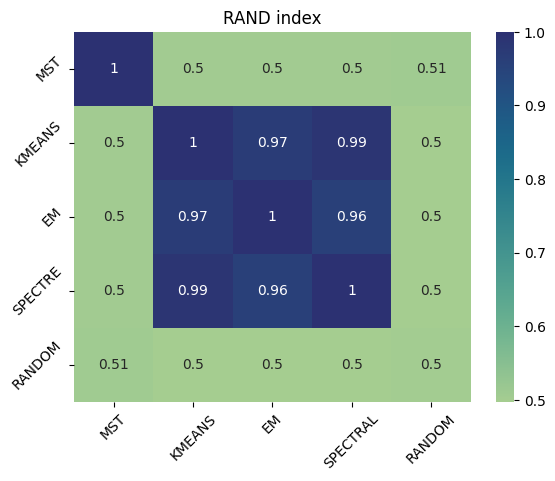

In [146]:
plt.title("RAND index")
g = sns.heatmap(
    rand_idx_matrix,
    annot=True,
    xticklabels=["MST", "KMEANS", "EM", "SPECTRAL", "RANDOM"],
    yticklabels=["MST", "KMEANS", "EM", "SPECTRE", "RANDOM"],
    cmap="crest",
)
if g.get_yticklabels():
    g.set_yticklabels(labels=g.get_yticklabels(), rotation=45)
if g.get_xticklabels():
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

Значения RAND индексов говорят о том, что алгоритьмы EM, K-Means и Spectral получают очень похожие между собой разбиения, отличные от разбиений полученных MST и случайными алгоритмами. В то же время, MST получает разбиения, не похожие ни на вышеупомянутые алгоритмы, ни на случайный алгоритм.
Это также подтверждается двумерными картами полученных разбиений: по ним видно, что EM, K-Means и Spectral получают одинаковые разбиения, а MST-алгоритм получает абсолютно другое разбиение.

Под рандомным алгоритмом здесь имеется в виду следующее:
1) Было сделано 100 случайных разбиений графа
2) Для каждого такого разбиения считался RAND индекс с каждым разбиением, полученным другим методом, после чего значения были усреднены.
3) Чтобы получить RAND индекс пары (случайный алгоритм, случайный алгоритм), были посчитаны RAND индексы между всеми случайными разбиениями и затем усреднены.

In [147]:
mfn_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    mfn_rand.append(nx.community.modularity(G, rpart))

In [148]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    print(f"{part_name} clustering modularity value:", nx.community.modularity(G, part))
print("RANDOM clustering modularity value:", sum(mfn_rand) / 100)

MST clustering modularity value: 0.015237235489113599
KMEANS clustering modularity value: 0.05653391618453851
EM clustering modularity value: 0.05642951505083127
SPECTRAL clustering modularity value: 0.05653874570735082
RANDOM clustering modularity value: -0.002481928719801474


Значения модулярности для разбиений, полученных вышеописанными алгоритмами получились довольно маленькими, но все же относительно сильно больше, чем для случайных разбиений. Из этого можно предположить, что алгоритмы кластеризовали данные  лучше чем случайная кластеризация.

Также видно, что значения функции модулярности у EM, K-Means и Spectral алгоритмов почти равны, что вкупе с индексами RAND и двумерными картами для этих пар говорит о том, что эти алгоритмы получают очень похожие разбиения. MST алгоритм же получает совсем другие разбиения, и значение функции модулярности для него в несколько раз меньше, чем для других алгоритмов, что может говорить о том, что вершины в кластерах, полученных этим алгоритмом, слабее связаны в контексте полученной нами матрицы similarity.

В то же время, визуальный анализ показывает, что именно MST правильно разбил данные на 2 кластера.

In [149]:
def get_labels_from_clusters(clusters):
    labels = np.zeros(sum([len(c) for c in clusters]), dtype=int)
    for i, cluster in enumerate(clusters):
        labels[list(cluster)] = i
    return labels

In [150]:
sil_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    sil_rand.append(silhouette_score(X, get_labels_from_clusters(rpart)))

#### Подсчет Silhouette Score

Silhouette score отражает близость каждого наблюдения к точкам из своего кластера и других кластеров. Данная метрика задается следующим образом:

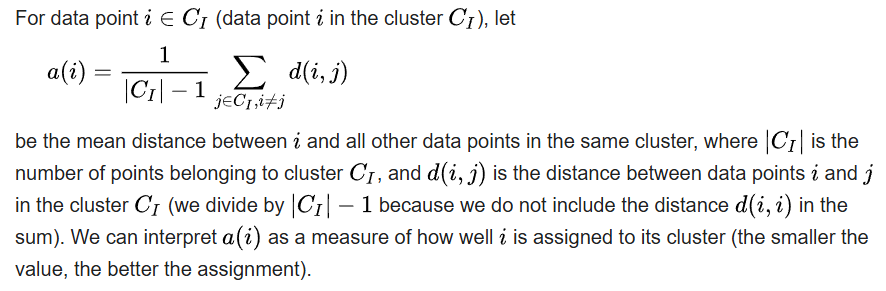
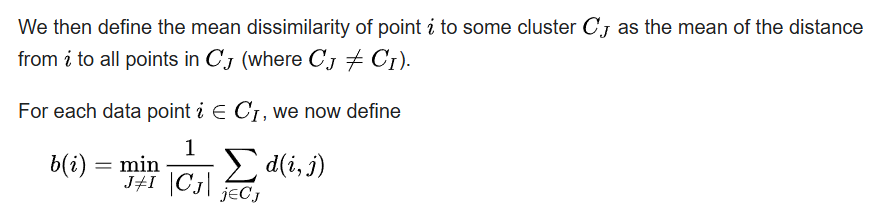
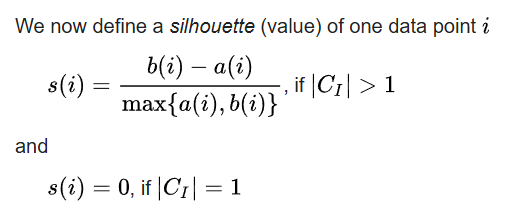

In [151]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    cur_labels = get_labels_from_clusters(part)
    print(f'{part_name} silhouette score: {silhouette_score(X, cur_labels)}')
    
print("RANDOM silhouette score:", sum(sil_rand) / 100)

MST silhouette score: 0.06764033477920667
KMEANS silhouette score: 0.41765239906467655
EM silhouette score: 0.41800095023507605
SPECTRAL silhouette score: 0.4175053862958213
RANDOM silhouette score: -0.0008442509857671829


## Оценка оптимального количества кластеров известными методами

#### 1) Оценка оптимального количества кластеров методом локтя

Для реализации данного метода, мы кластерезуем наши наблюдения некоторое количество раз варьируя k (количество кластеров от 1 до некоторого верхнего значения). Для каждого k мы считаем WCSS (within-cluster sum of squares) и строим график зависимости WCSS от k.

Суть метода заключается в том, что оптимальное k можно определить по графику: точка, соответсвующая k будет "локтевой", то есть если увеличивать k относительно оптимального, WCSS будет оставаться на плато.

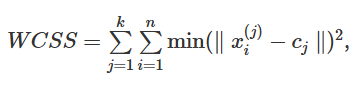

Для определения локтевой точки будем использовать ансамбль из двух линейных регрессий, точкой перелома (локтя) выберем ту, при разбиении по которой получается оптимальное значение R2.

In [ ]:
def two_reg_elbow_find(metrics):
    R2_scores = []
    for i in range(len(metrics)):
        L1, L2 = LinearRegression(), LinearRegression()
        x = np.arange(1, len(metrics)+1)[..., np.newaxis]
        left_x, right_x = x[:i], x[i:]
        left_y, right_y = metrics[:i], metrics[i:]
        if len(left_x) == 0:
            preds = np.asarray([])
        else:
            preds = L1.fit(left_x, left_y).predict(left_x)

        if len(right_x) > 0:
            preds = np.concatenate([preds, L2.fit(right_x, right_y).predict(right_x)])
        
        R2_scores.append(r2_score(np.asarray(metrics), preds))
    
    R2_scores = np.asarray(R2_scores)
    return np.argmax(R2_scores)+1

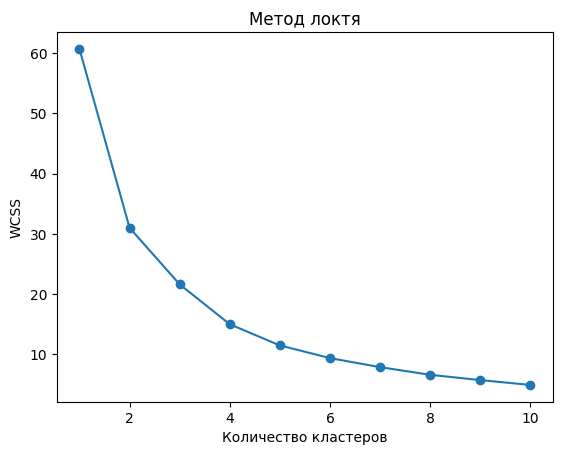

In [153]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=54).fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя')
plt.show()

In [159]:
two_reg_elbow_find(wcss)

3

По методу локтя точно нельзя сказать, какое количество кластеров оптимально в данном случае, ведь на графике нельзя однозначно выделить "локтевую" точку.

#### 2) Оценка оптимального количества кластеров с помощью собственных значений лапласиана графа

Основываясь на том что кратность собственного значения лапласиана, равного нулю равна количеству компонент связности графа, построим на графике все собственные значения и попытаемся сделать вывод об оптимальном количестве кластеров

In [155]:
D_sq = np.diag([1 / np.sqrt(W.shape[0]) for i in range(W.shape[0])])
Lsym = D_sq @ L @ D_sq
eig_vals_sym, eig_vecs_sym = np.linalg.eigh(Lsym)

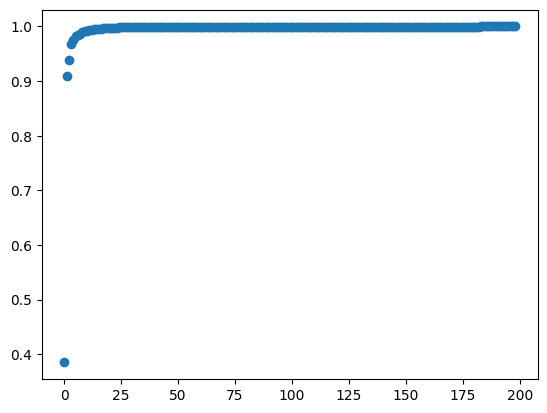

In [156]:
plt.scatter(list(range(len(eig_vals_sym))), eig_vals_sym)

Из графика видно, что самое близкое к нулю собственное значение лапласиана равно примерно 0.35, а следующее собственное значение довольно близко к единице, поэтому данный метод не очень согласуется с нашими предыдущими выводами, хотя конечно можно сказать, что первые 3 собственных значения все же выделяются на графике и это говорит о том, что оптимальные значение для k согласно данному методу - это 3.

Для этого набора данных можно утверждать, что оптимальное количество кластеров наиболее хорошо определяется визуально, так как на 2D-карте отчетливо видно 2 группы наблюдений. На двумерном графике видна достаточно нетривиальная структура кластеров, которую такие алгоритмы как K-Means не умеют определять. Вряд ли удастся с помощью какой-либо численной метрики определить оптимальное число кластеров, так как все они (по крайней мере те, про которые нам удалось вычитать) основаны на расстояниях внутри кластеров.